# PCA mit Logistic Regression

In diesem Notebook erweitern wir die `Logistic Regression` mit einem `Preprocessing`.

Das `Preprocessing` ist eine `Dimensions-Reduktion` von 3072 Features auf 200 PC-Features mittels `PCA`.
Analog zum Aufgabenblatt 3 visualisieren wir diese Hauptkomponenten und die Rekonstruktion der Originalbilder.

Die `Logistic Regression` wird auf diesen 200 PC-Features trainiert und evaluiert.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

import pickle

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import numpy as np

import pandas as pd

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [2]:
def plot_confusion_matrix(y_true: any, y_pred: any):
    """
        Takes true and predicted labels (arrays) as input. Based on this, calculates and plots a confusion matrix.
    """
    labels = np.unique(y_true)
    fig = plt.figure(figsize=(len(labels), len(labels)))
    ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels, normalize='all'),
      display_labels=labels
    ).plot(ax=fig.gca(), cmap="BuPu", xticks_rotation='vertical', include_values=True)
    plt.show()

In [3]:
def plot_image_grid(images, N=10, image_size=(32, 32, 3), random=False, title=''):
    ''' Utility plotting function to display NxN images on a grid.

    Reshaping of image vector into 2d-array of size image_size.
    '''

    fig, axs = plt.subplots(N,N, figsize=(15,15))
    idxs = np.arange(0,images.shape[0])
    if random:
        idxs = np.random.permutation(idxs)
    for idx, ax in enumerate(axs.flatten()):
        ax.imshow(
            images[idxs[idx]].reshape(*image_size),
            interpolation='none',
            cmap='gray_r'
        )
        # do not show the axis ticks
        ax.get_yaxis().set_visible(False)
        ax.get_xaxis().set_visible(False)

    if len(title) > 0:
        st = fig.suptitle(title, fontsize=14)
        fig.tight_layout()
        st.set_y(0.95)
        fig.subplots_adjust(top=0.93)

# Daten vorbereiten

In [4]:
# Daten laden und aufteilen in Features und Labels
with open('../data/train.pkl', 'rb') as f:
    data_train = pickle.load(f)
X_data = data_train["images"]
y_data = data_train["labels"]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, random_state=42)

## PCA

Bevor wir unser Modell erstellen, untersuchen wir die `Hauptkomponenten`, die wir mit PCA finden.

### Visualisierung

Zuerst untersuchen wir den Einfluss der Hauptkomponenten auf die erklärte Varianz.

Dies kann helfen die Anzahl der Hauptkomponente (`n_components`) effizient zu wählen.

In [6]:
%%time

pca = Pipeline([
    ('std', StandardScaler()), # Für PCA sollte man die Achsen standardisieren
    ('pca', PCA(n_components=0.99).fit(X_train.reshape(-1, 32 * 32 * 3)))
])

plt.title("Wie entwickelt sich die Wichtigkeit der Hauptkomponenten (log-scale)")
plt.plot(pca['pca'].explained_variance_ratio_)
plt.yscale('log')
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Beitrag zur erklärten Varianz auf dem Datensatz")
plt.show()

plt.title("Wie entwickelt sich die erklärte Varianz")
plt.plot(np.cumsum(pca['pca'].explained_variance_ratio_))
plt.xlabel("Anzahl Hauptkomponenten")
plt.ylabel("Erklärte Varianz auf dem Datensatz")
plt.show()

with np.printoptions(threshold=np.inf):
    print("Wie viel Varianz erklären die ersten 200 Hauptkomponenten:")
    print(np.cumsum(pca['pca'].explained_variance_ratio_[:200]))

KeyboardInterrupt: 

In [7]:
def scale_between_1_and_0(X):
  return (X - np.min(X)) / (np.max(X) - np.min(X))

Hier visualisieren wir die ersten 100 Hauptkomponenten:

In [8]:
%%time

pca = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=200))
]).fit(X_train.reshape(-1, 32 * 32 * 3))

print(X_train.reshape(-1, 32 * 32 * 3).shape)
print(pca.transform(X_train.reshape(-1, 32 * 32 * 3)).shape)
n_components_90 = pca['pca'].n_components_

print("200 with " + str(np.sum(pca['pca'].explained_variance_ratio_)) + "% Varianz explained")

(37500, 3072)
(37500, 200)
200 with 0.9446330340514265% Varianz explained
CPU times: user 1min 21s, sys: 11.2 s, total: 1min 32s
Wall time: 23.8 s


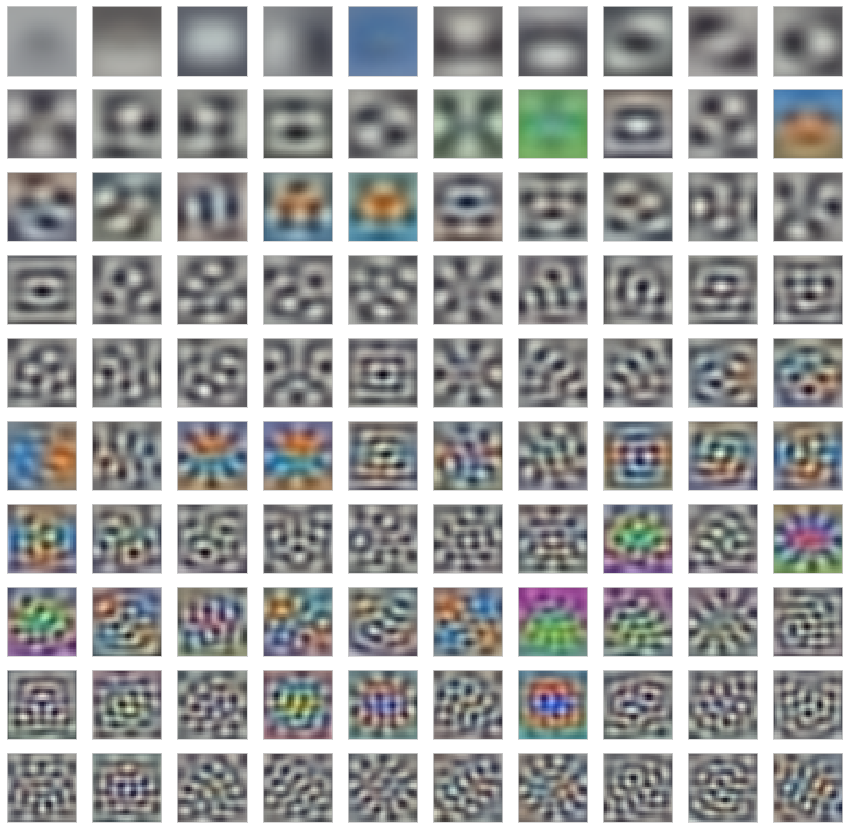

In [9]:
plot_image_grid(scale_between_1_and_0(pca['pca'].components_))

Man erkennt, dass die Hauptkomponenten generelle Muster beschreiben. Wir untersuchen jetzt, wie gut die Rekonstruktion der Bilder mittels dieser ersten 100 Hauptkomponenten aussieht:

In [10]:
# PCA-Rekonstruktionen berechnen durch Transformation und inverse Transformation
X_train_reconstructed = pca.inverse_transform(pca.transform(X_train.reshape(-1, 32 * 32 * 3)))

# Sicherstellen, dass die Werte in einem validen Intervall zwischen 0 und 255 liegen
X_train_reconstructed = np.clip(X_train_reconstructed, 0, 255).astype(int)

plot_image_grid(
    np.hstack([X_train.reshape(-1, 32 * 32 * 3), X_train_reconstructed]).reshape((-1, 32 * 32 * 3)),
    N=10,
    title="original and reconstruction"
)
plt.show()


KeyboardInterrupt: 

Rekonstruktion step by step:

In [ ]:
img = X_train[0]
img_pca = pca.transform(img.reshape(-1, 32 * 32 * 3))

plt.title('Beispiel Bild')
plt.imshow(img)
plt.axis('off')
plt.show()

images = []
for i in range(200):
    img_pca_single = np.zeros(shape=img_pca.shape, dtype=float)
    img_pca_single[:, i] = img_pca[:, i]
    images.append(scale_between_1_and_0(
        pca['pca'].inverse_transform(img_pca_single)
    ))

plot_image_grid(np.array(images), title='Rekonstruktion exklusive Hauptkomponenten vom Beispielbild')

images = []
for i in range(200):
    img_pca_single = np.zeros(shape=img_pca.shape, dtype=float)
    img_pca_single[:, :(i + 1)] = img_pca[:, :(i + 1)]
    images.append(scale_between_1_and_0(
        pca['pca'].inverse_transform(img_pca_single)
    ))

plot_image_grid(np.array(images), title='Rekonstruktion aggregierter Hauptkomponenten vom Beispielbild')

Wir sehen, dass die Bilder mehrheitlich gut rekonstruiert werden, aber ein wenig verschommen sind.
Es ist schwieriger das Objekt auf der Rekonstruktion zu erkennen als auf den Originalbildern.

### Logistische Regression mit PCA

Hier trainieren wir ein Modell und nehmen die ersten 200 Hauptkomponenten.
Wir reduzieren die 3072 Features (`32 * 32 * 3` Pixel) zuerst mittels `PCA` auf 200 Features und trainieren anschliessend auf diesen 200 Features eine `Logistic Regression`.

![PCA + Logistic Regression](./img/pca_logistic_regression.png)

In [ ]:
%%time

pca_lr = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA(n_components=200)),
    ('clf', LogisticRegression(max_iter=1000))
])

pca_lr.fit(X_train.reshape(-1, 32 * 32 * 3), y_train)

print("Anzahl Iterationen", pca_lr['clf'].n_iter_)

y_train_hat = pca_lr.predict(X_train.reshape(-1, 32 * 32 * 3))
print("Train: ", accuracy_score(y_train_hat, y_train))

y_val_hat = pca_lr.predict(X_val.reshape(-1, 32 * 32 * 3))
print("Val:   ", accuracy_score(y_val_hat, y_val))

In [ ]:
plot_confusion_matrix(y_true=y_val, y_pred=y_val_hat)

# Anwendung des Modells auf dem Test Set

Wenn wir mit der Leistung unseres Modells auf dem `Validation Set` zufrieden sind, können wir es auf das `Test Set` anwenden.

In [ ]:
# Daten laden und aufteilen in Features und Labels
with open('../data/test.pkl', 'rb') as f:
    data_test = pickle.load(f)
X_test = data_test["images"]
y_test = data_test["labels"]

In [ ]:
y_test_pred = pca_lr.predict(X_test.reshape(-1, 32 * 32 * 3))

Evaluieren wir unsere test-set predictions

In [ ]:
accuracy_score(y_true=y_test, y_pred=y_test_pred)